In [1]:
# !pip3 install 'Keras>=2.3.1' 'tensorflow>=2.0.0' 'scikit-image>=0.16.1'
# !pip3 install 'scikit-learn>=0.21.3' 'opencv-contrib-python>=4.1.1.26'
# !pip3 install 'numpy>=1.17.2' 'scipy>=1.3.1' 'tqdm>=4.36.1'

In [2]:
import sys

sys.path.append('../')

import sys
import time
import numpy
import pickle
from skimage.io import imread, imsave
from matplotlib import pyplot

from yeastcells.models import load_unet_model
from yeastcells.pipeline import pipeline

Using TensorFlow backend.
/home/herbert/.virtualenvs/yeastcells/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Loading AI models

In [3]:
model_file = f'../models/model-2019-06-03-97.8.hd5'
elimination_model_file = f'../models/false-positive-eliminator.p3'

In [9]:
cell_localisation_model = load_unet_model(model_file)

with open(elimination_model_file, 'rb') as f:
    false_positive_eliminator = pickle.load(f)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Predictions

In [10]:
X = imread('../example_movie_small.tif') / 65535.0
# imsave('../example_movie_small.tif', X[50:100])

In [11]:
result = pipeline(
    X,
    false_positive_eliminator = false_positive_eliminator,
    cell_localisation_model = cell_localisation_model
)

result_ = result.to_dict()

predicting using U-NET...
Took    31.26s
Determining cell centers...
Took     2.41s
Clustering coordinates across frames...
Took     1.16s
Finding cell boundaries using seam carving, this takes many minutes...


Took   106.07s
Finding features for the path, including the average radius and how non-circular it is...
Took     0.13s
Finding false positives...


## Results

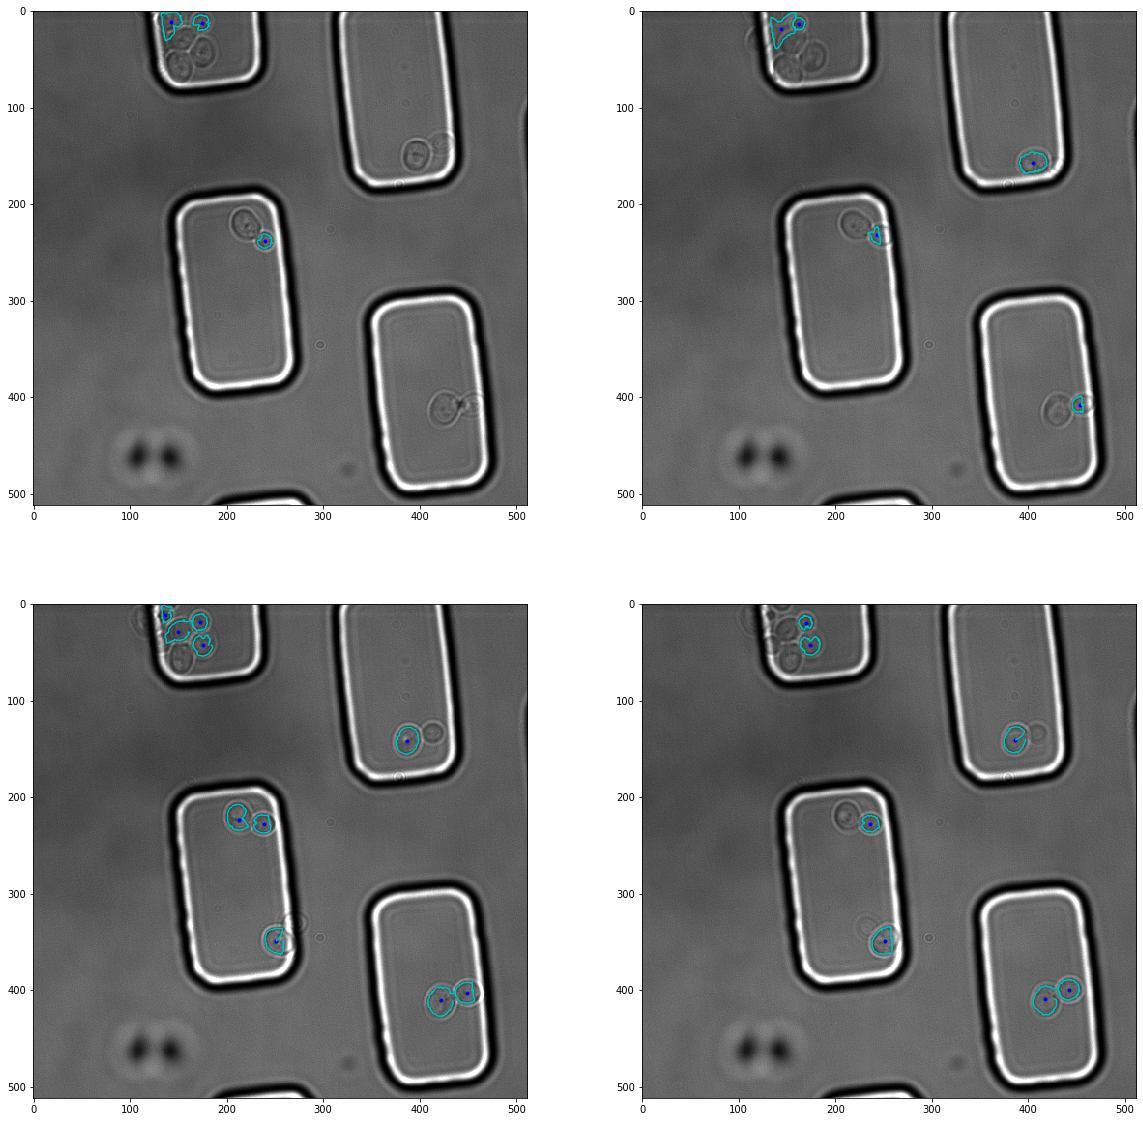

In [12]:
fig, axes = pyplot.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()


for axis, t in zip(axes, numpy.random.permutation(len(X))):
    axis.imshow(X[t, ..., :1] * [[[1, 1, 1]]]) # RGB
    for cell in result_:
        for frame in cell:
            x, y, t_ = frame['center']
            if t == int(t_):
                axis.plot([x], [y], '.b')
                x, y = zip(*frame['boundary'])
                axis.plot(x, y, '-c')
                